In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.functional import kl_div

torch.manual_seed(1337)

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Define the loss functions
    ce_loss_func = nn.CrossEntropyLoss()

    # Prepare dictionaries to store the output losses
    dlite_out = {}
    ce_out = {}
    kl_out = {}
    dlite_cuberoot_out = {}
    lit_out = {}

    model.eval()  # Set the model to evaluation mode
    for split in ['train', 'val']:
        dlite_losses = torch.zeros(eval_iters)
        ce_losses = torch.zeros(eval_iters)
        kl_losses = torch.zeros(eval_iters)
        dlite_cuberoot_losses = torch.zeros(eval_iters)
        lit_losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)

            # Reshape the logits
            logits_flat = logits.view(-1, logits.size(-1))  # Flattening the logits

            # Convert targets to one-hot encoding
            targets_flat = Y.view(-1)

            # Calculate the losses
            dlite_losses[k] = dlite_loss(logits_flat, targets_flat).item()
            ce_losses[k] = ce_loss_func(logits_flat, targets_flat).item()  # Assuming vocab_size is the same as logits.size(-1)
            kl_losses[k] = kl_loss(logits_flat, targets_flat).item()
            dlite_cuberoot_losses[k] = dlite_cuberoot_loss(logits_flat, targets_flat).item()
            lit_losses[k] = lit_loss(logits_flat, targets_flat).item()

        # Store the mean loss for each metric
        dlite_out[split] = dlite_losses.mean().item()
        ce_out[split] = ce_losses.mean().item()
        kl_out[split] = kl_losses.mean().item()
        dlite_cuberoot_out[split] = dlite_cuberoot_losses.mean().item()
        lit_out[split] = lit_losses.mean().item()


    model.train()  # Set the model back to training mode
    return dlite_out, ce_out, kl_out, dlite_cuberoot_out, lit_out



class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, targets=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)

        if targets is not None:
            # Calculate L1 Loss
            B, T, C = out.shape
            out_flat = out.view(B * T, C)
            targets_flat = targets.view(B * T)
            l1_loss = F.l1_loss(out_flat, targets_flat.float())
            return out, l1_loss
        else:
            return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# DLITE Loss function
class DLITELoss(nn.Module):
    def __init__(self):
        super(DLITELoss, self).__init__()

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Masks for non-zero elements of probs and true_probs
        mask_probs = probs > 0
        mask_true_probs = true_probs > 0

        # Calculate g function for non-zero elements using the mask
        g_probs = torch.zeros_like(probs)
        g_true_probs = torch.zeros_like(true_probs)
        g_probs[mask_probs] = probs[mask_probs] * (1 - torch.log(probs[mask_probs]))
        g_true_probs[mask_true_probs] = true_probs[mask_true_probs] * (1 - torch.log(true_probs[mask_true_probs]))
        g_values = torch.abs(g_probs - g_true_probs)

        # Calculate delta_h function for non-zero elements using the mask
        delta_h_probs = torch.zeros_like(probs)
        delta_h_true_probs = torch.zeros_like(true_probs)
        delta_h_probs[mask_probs] = probs[mask_probs]**2 * (1 - 2 * torch.log(probs[mask_probs]))
        delta_h_true_probs[mask_true_probs] = true_probs[mask_true_probs]**2 * (1 - 2 * torch.log(true_probs[mask_true_probs]))
        delta_h_values = torch.abs(delta_h_probs - delta_h_true_probs) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values

        # Sum over all classes and average over the batch size
        loss = dl_values.sum(dim=-1).mean()

        return loss


# DLITE Cube Root Loss function
class DLITECubeRootLoss(nn.Module):
    def __init__(self):
        super(DLITECubeRootLoss, self).__init__()

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Masks for non-zero elements of probs and true_probs
        mask_probs = probs > 0
        mask_true_probs = true_probs > 0

        # Calculate g function for non-zero elements using the mask
        g_probs = torch.zeros_like(probs)
        g_true_probs = torch.zeros_like(true_probs)
        g_probs[mask_probs] = probs[mask_probs] * (1 - torch.log(probs[mask_probs]))
        g_true_probs[mask_true_probs] = true_probs[mask_true_probs] * (1 - torch.log(true_probs[mask_true_probs]))
        g_values = torch.abs(g_probs - g_true_probs)

        # Calculate delta_h function for non-zero elements using the mask
        delta_h_probs = torch.zeros_like(probs)
        delta_h_true_probs = torch.zeros_like(true_probs)
        delta_h_probs[mask_probs] = probs[mask_probs]**2 * (1 - 2 * torch.log(probs[mask_probs]))
        delta_h_true_probs[mask_true_probs] = true_probs[mask_true_probs]**2 * (1 - 2 * torch.log(true_probs[mask_true_probs]))
        delta_h_values = torch.abs(delta_h_probs - delta_h_true_probs) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values

        # Sum over all classes and average over the batch size
        loss = dl_values.sum(dim=-1).mean() ** 1/3

        return loss


# LIT Loss function
class LITLoss(nn.Module):
    def __init__(self):
        super(LITLoss, self).__init__()

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Masks for non-zero elements of probs and true_probs
        mask_probs = probs > 0
        mask_true_probs = true_probs > 0

        # Calculate g function for non-zero elements using the mask
        g_probs = torch.zeros_like(probs)
        g_true_probs = torch.zeros_like(true_probs)
        g_probs[mask_probs] = probs[mask_probs] * (1 - torch.log(probs[mask_probs]))
        g_true_probs[mask_true_probs] = true_probs[mask_true_probs] * (1 - torch.log(true_probs[mask_true_probs]))
        g_values = torch.abs(g_probs - g_true_probs)


        # Sum over all classes and average over the batch size
        loss = g_values.sum(dim=-1).mean()

        return loss


class KLDivergenceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(KLDivergenceLoss, self).__init__()
        self.reduction = reduction

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)

        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()

        # Masks for non-zero elements of probs and true_probs
        mask_probs = probs > 0
        mask_true_probs = true_probs > 0

        # Calculate g function for non-zero elements using the mask
        kl_values = torch.zeros_like(probs)
        kl_values[mask_true_probs] = true_probs[mask_true_probs] * torch.log(true_probs[mask_true_probs]/probs[mask_true_probs])

        # Sum over all classes and average over the batch size
        loss = kl_values.sum(dim=-1).mean()

        return loss





# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.loss_func = DLITELoss()  # Initialize the DLITE loss function

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = self.loss_func(logits, targets)  # Use DLITE loss here

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



## Hyperparameters

In [4]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

## Train with DLITE

0.209729 M parameters
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 3.3285, KL val loss 3.4019
DLITE train loss 0.6724, DLITE val loss 0.6736
CE train loss 3.3285, CE val loss 3.4019
DLITE Cube Root train loss 0.2241, DLITE Cube Root val loss 0.2245
LIT train loss 3.0371, LIT val loss 3.0244

step 200: KL train loss 3.3348, KL val loss 3.4162
DLITE train loss 0.6473, DLITE val loss 0.6496
CE train loss 3.3348, CE val loss 3.4162
DLITE Cube Root train loss 0.2158, DLITE Cube Root val loss 0.2165
LIT train loss 2.7270, LIT val loss 2.7251

step 300: KL train loss 3.3302, KL val loss 3.4447
DLITE train loss 0.6312, DLITE val loss 0.6367
CE train loss 3.3302, CE val loss 3.4447
DLITE Cube Root train loss 0.2104, DLITE Cube Root val loss 0.2122
LIT train loss 2.5815, L

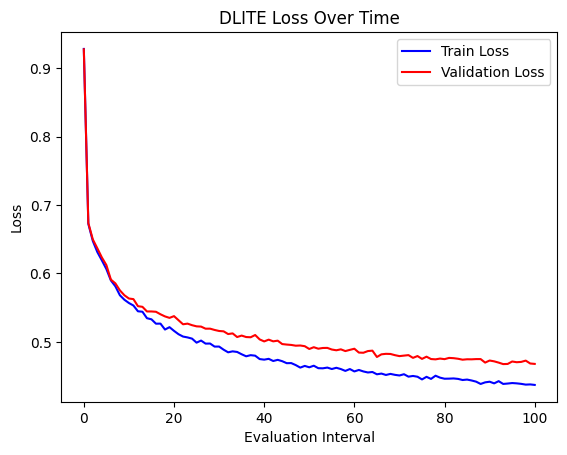

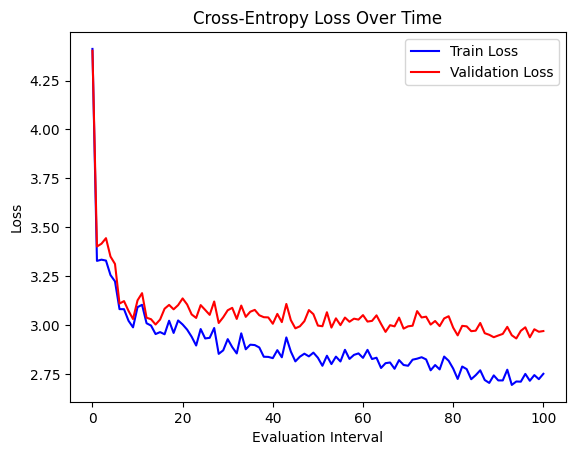

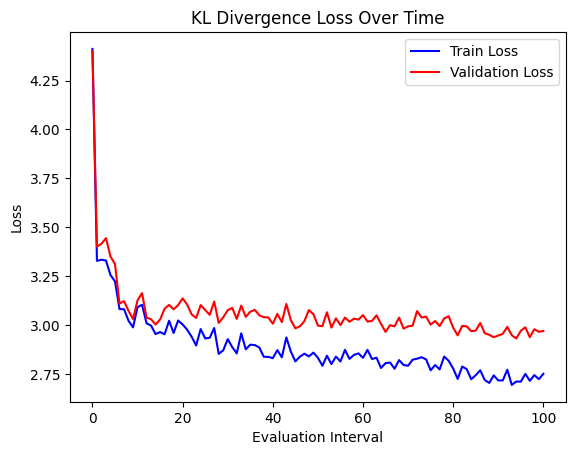

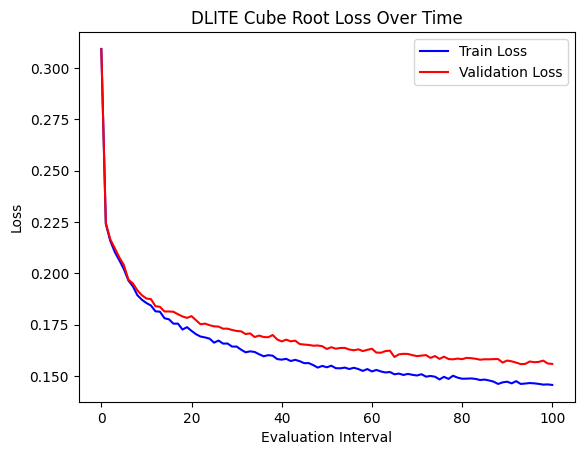

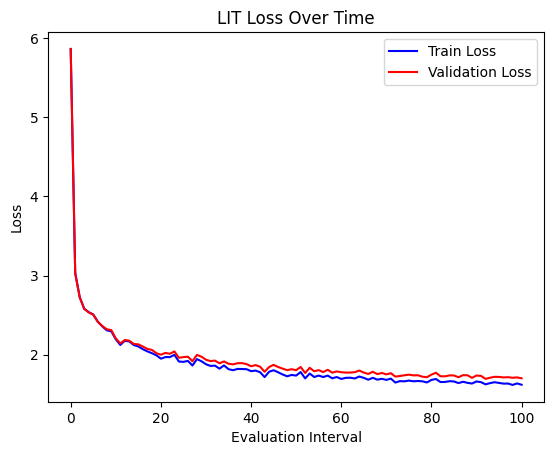

In [30]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []




for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


!pip install matplotlib
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')



## Train with CE

0.209729 M parameters
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 2.6568, KL val loss 2.6670
DLITE train loss 0.6977, DLITE val loss 0.6981
CE train loss 2.6568, CE val loss 2.6670
DLITE Cube Root train loss 0.2326, DLITE Cube Root val loss 0.2327
LIT train loss 4.1986, LIT val loss 4.2068

step 200: KL train loss 2.5091, KL val loss 2.5060
DLITE train loss 0.6712, DLITE val loss 0.6701
CE train loss 2.5091, CE val loss 2.5060
DLITE Cube Root train loss 0.2237, DLITE Cube Root val loss 0.2234
LIT train loss 3.9304, LIT val loss 3.9325

step 300: KL train loss 2.4199, KL val loss 2.4337
DLITE train loss 0.6491, DLITE val loss 0.6506
CE train loss 2.4199, CE val loss 2.4337
DLITE Cube Root train loss 0.2164, DLITE Cube Root val loss 0.2169
LIT train loss 3.7271, L

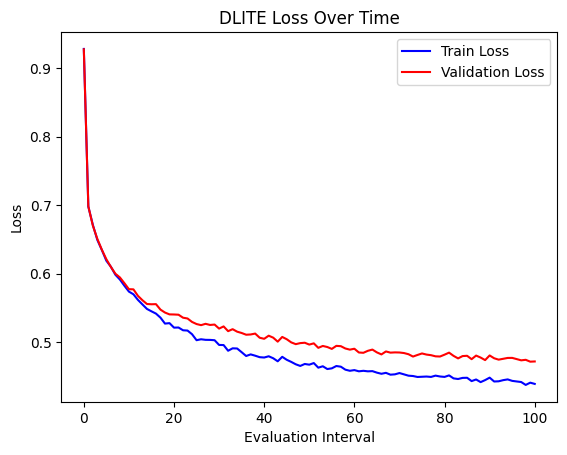

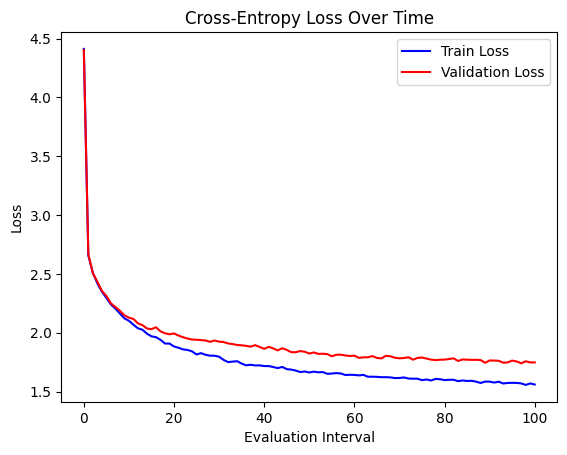

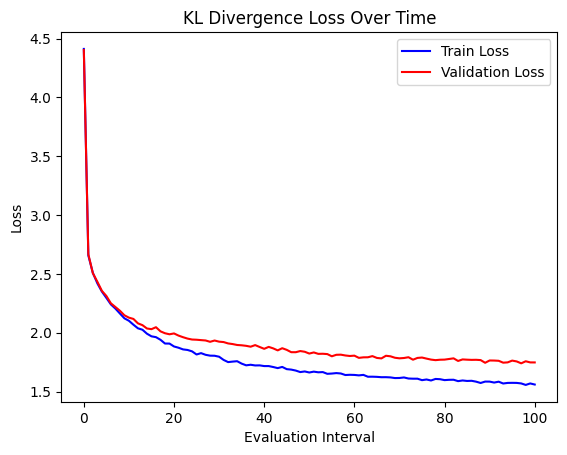

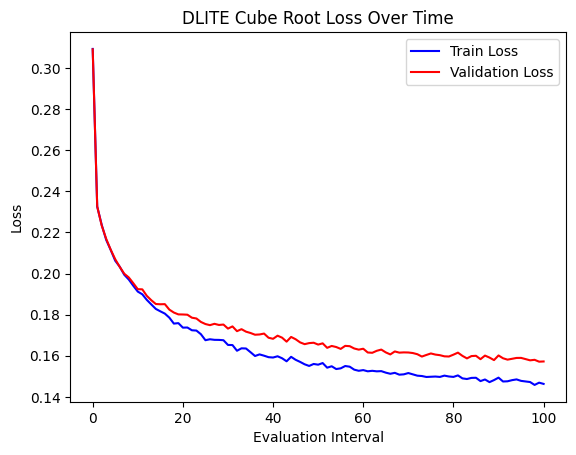

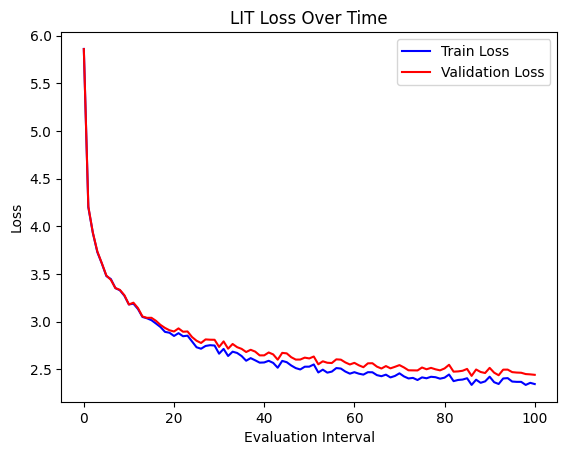

In [31]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []




for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the CE loss using the flattened logits and targets
    loss = ce_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()



# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')





## Train with KL divergence loss

0.209729 M parameters
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 2.6568, KL val loss 2.6670
DLITE train loss 0.6977, DLITE val loss 0.6981
CE train loss 2.6568, CE val loss 2.6670
DLITE Cube Root train loss 0.2326, DLITE Cube Root val loss 0.2327
LIT train loss 4.1988, LIT val loss 4.2071

step 200: KL train loss 2.5089, KL val loss 2.5057
DLITE train loss 0.6711, DLITE val loss 0.6700
CE train loss 2.5089, CE val loss 2.5057
DLITE Cube Root train loss 0.2237, DLITE Cube Root val loss 0.2233
LIT train loss 3.9304, LIT val loss 3.9325

step 300: KL train loss 2.4194, KL val loss 2.4334
DLITE train loss 0.6490, DLITE val loss 0.6506
CE train loss 2.4194, CE val loss 2.4334
DLITE Cube Root train loss 0.2163, DLITE Cube Root val loss 0.2169
LIT train loss 3.7267, L

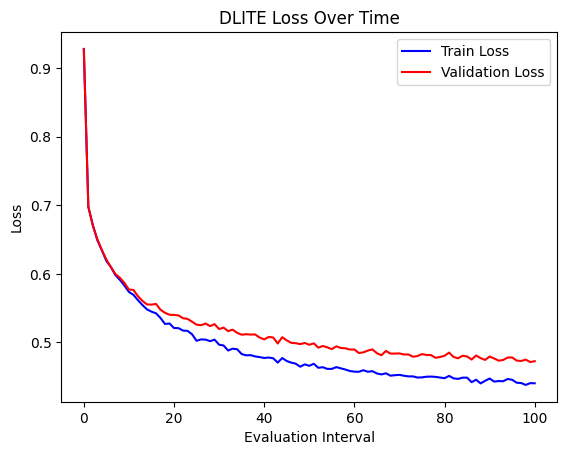

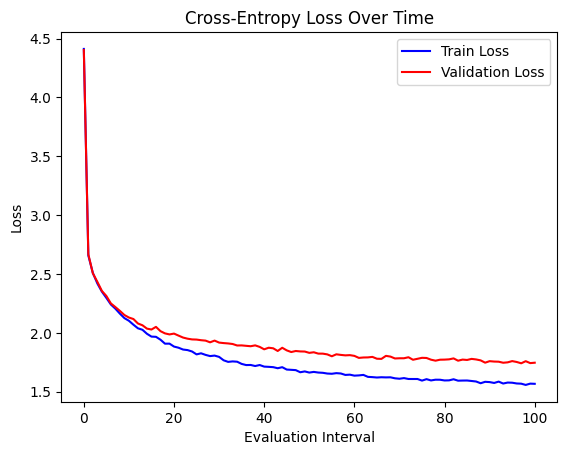

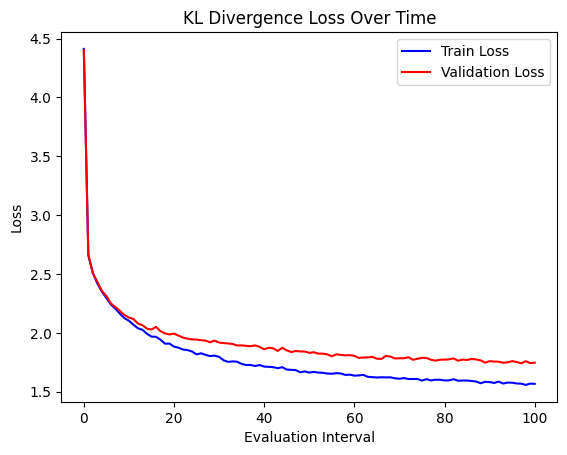

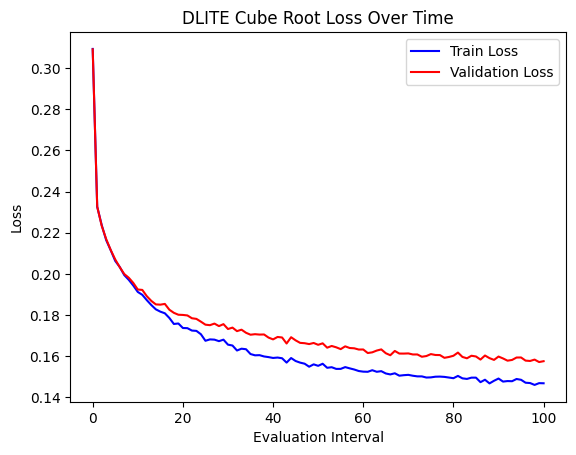

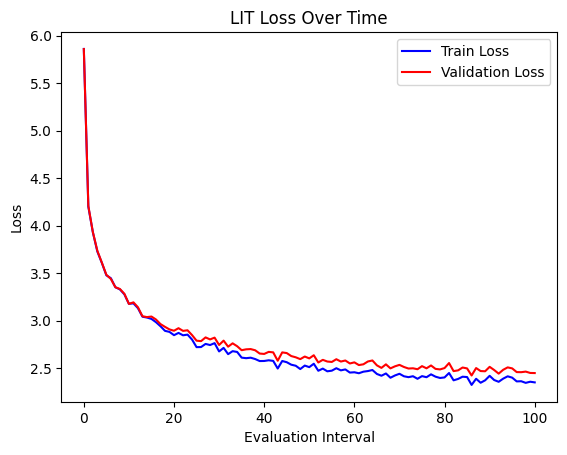

In [32]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []




for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # Compute the KL Divergence loss using the flattened logits and targets
    kl_loss_value = kl_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    kl_loss_value.backward()
    optimizer.step()


# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')


## Train with DLITE and CE

In [6]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []

# lf: 0 for CE, 1 for DLITE loss function
def run(lf):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)
    
    if(lf==0):
        # Compute the CE loss using the flattened logits and targets
        loss = ce_loss(logits_flat, targets_flat)
    else:
        # Compute the DLITE loss using the flattened logits and targets
        loss = dlite_loss(logits_flat, targets_flat)


    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# 5 alternative runs
run_splits = 5
for i in range(run_splits): 
    lf = 0 if i%2==0 else 1
    lf_name = "CE" if i%2==0 else "DL"
    print(f"Training based on {lf_name}")
    for iter in range(int(max_iters*i/run_splits), int(max_iters*(i+1)/run_splits)):
        run(lf)
    

# for iter in range(int(max_iters / run_splits)):
#     run(0)

# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')


0.209729 M parameters
Training based on CE
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 2.6568, KL val loss 2.6670
DLITE train loss 0.6977, DLITE val loss 0.6981
CE train loss 2.6568, CE val loss 2.6670
DLITE Cube Root train loss 0.2326, DLITE Cube Root val loss 0.2327
LIT train loss 4.1988, LIT val loss 4.2071

step 200: KL train loss 2.5090, KL val loss 2.5059
DLITE train loss 0.6711, DLITE val loss 0.6700
CE train loss 2.5090, CE val loss 2.5059
DLITE Cube Root train loss 0.2237, DLITE Cube Root val loss 0.2233
LIT train loss 3.9302, LIT val loss 3.9323

step 300: KL train loss 2.4196, KL val loss 2.4336
DLITE train loss 0.6489, DLITE val loss 0.6505
CE train loss 2.4196, CE val loss 2.4336
DLITE Cube Root train loss 0.2163, DLITE Cube Root val loss 0.2168
LIT

NameError: name 'plot_losses' is not defined

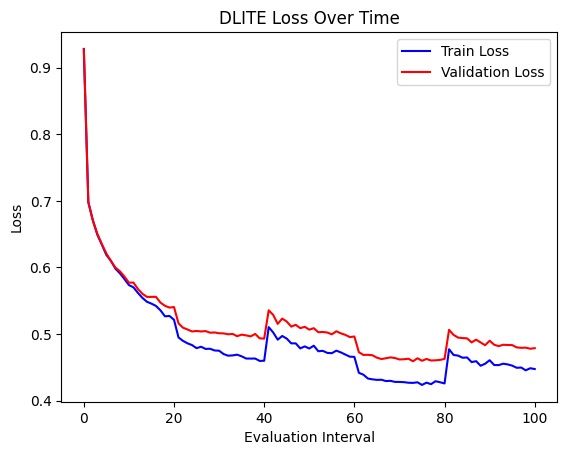

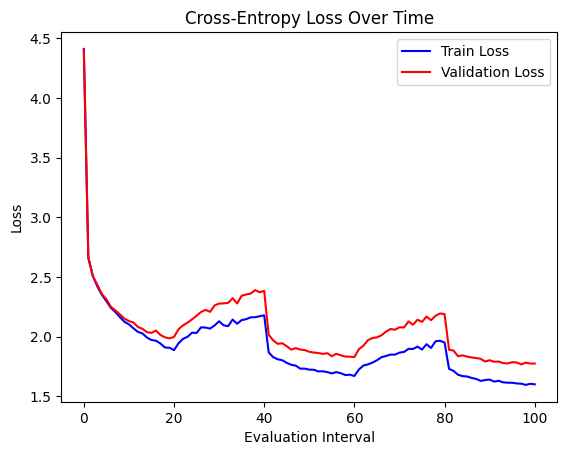

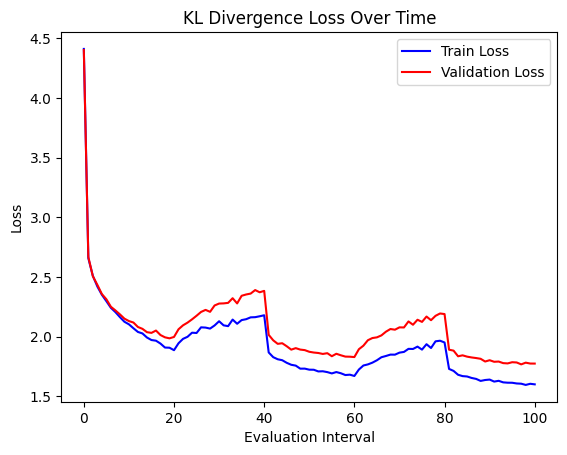

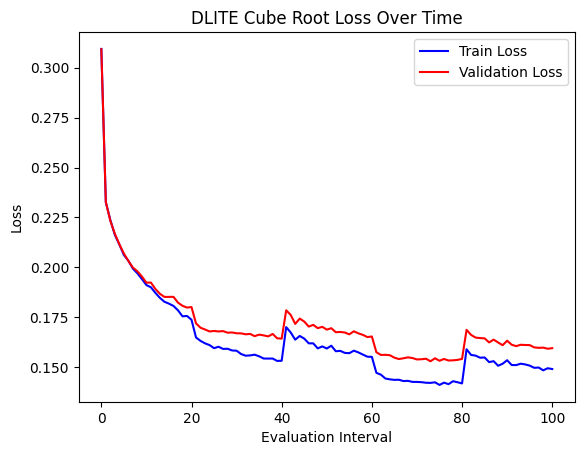

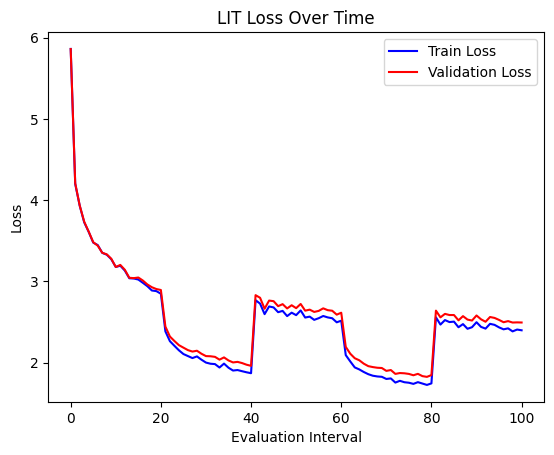

In [8]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()


# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')

## Train with DLITE Cube Root

0.209729 M parameters
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 3.3288, KL val loss 3.4022
DLITE train loss 0.6724, DLITE val loss 0.6736
CE train loss 3.3288, CE val loss 3.4022
DLITE Cube Root train loss 0.2241, DLITE Cube Root val loss 0.2245
LIT train loss 3.0366, LIT val loss 3.0239

step 200: KL train loss 3.3355, KL val loss 3.4168
DLITE train loss 0.6473, DLITE val loss 0.6496
CE train loss 3.3355, CE val loss 3.4168
DLITE Cube Root train loss 0.2158, DLITE Cube Root val loss 0.2165
LIT train loss 2.7260, LIT val loss 2.7242

step 300: KL train loss 3.3329, KL val loss 3.4475
DLITE train loss 0.6313, DLITE val loss 0.6368
CE train loss 3.3329, CE val loss 3.4475
DLITE Cube Root train loss 0.2104, DLITE Cube Root val loss 0.2123
LIT train loss 2.5798, L

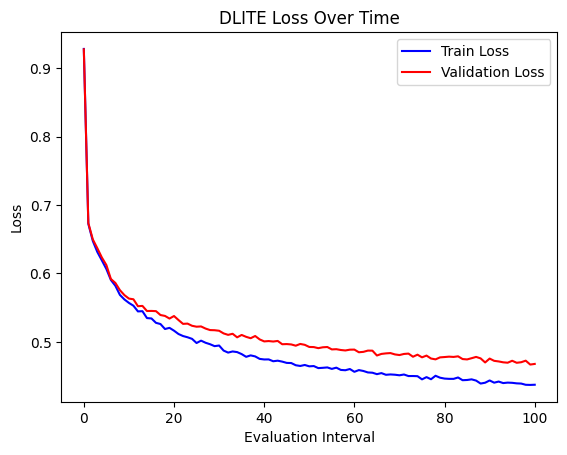

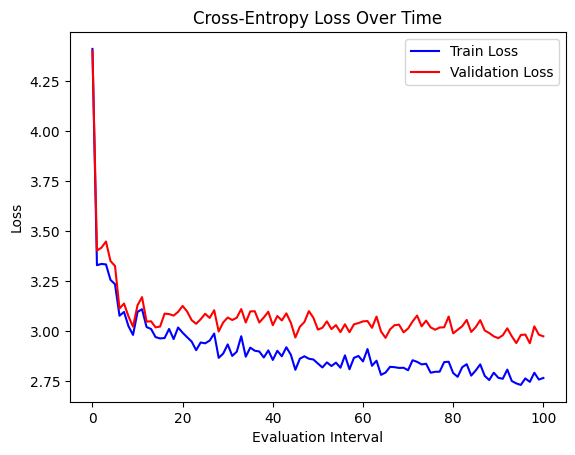

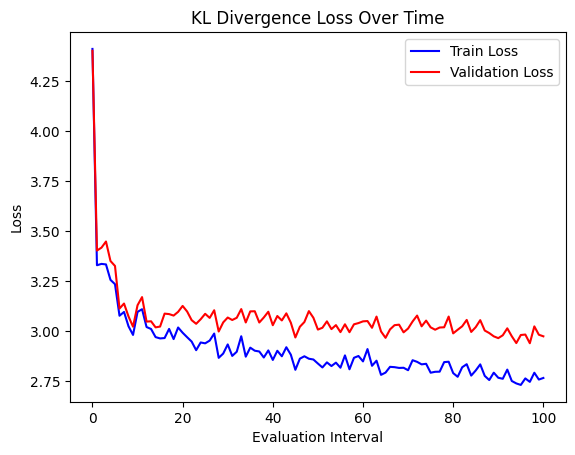

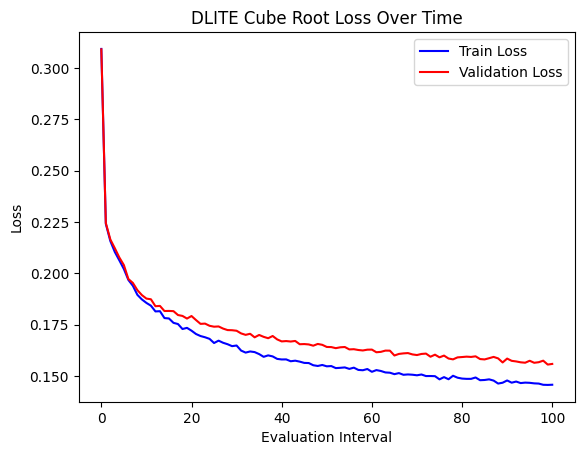

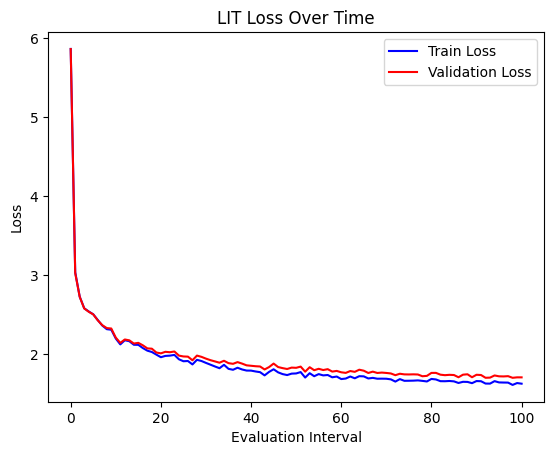

In [34]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []



for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])



    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_cuberoot_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


!pip install matplotlib
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()


# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')



## Train with LIT loss


0.209729 M parameters
step 0: KL train loss 4.4116, KL val loss 4.4022
DLITE train loss 0.9281, DLITE val loss 0.9275
CE train loss 4.4116, CE val loss 4.4022
DLITE Cube Root train loss 0.3094, DLITE Cube Root val loss 0.3092
LIT train loss 5.8604, LIT val loss 5.8589

step 100: KL train loss 8.9321, KL val loss 8.9730
DLITE train loss 0.8473, DLITE val loss 0.8514
CE train loss 8.9321, CE val loss 8.9730
DLITE Cube Root train loss 0.2824, DLITE Cube Root val loss 0.2838
LIT train loss 1.7170, LIT val loss 1.7252

step 200: KL train loss 9.8126, KL val loss 9.8599
DLITE train loss 0.8475, DLITE val loss 0.8516
CE train loss 9.8126, CE val loss 9.8599
DLITE Cube Root train loss 0.2825, DLITE Cube Root val loss 0.2839
LIT train loss 1.7036, LIT val loss 1.7118

step 300: KL train loss 10.3810, KL val loss 10.4245
DLITE train loss 0.8478, DLITE val loss 0.8518
CE train loss 10.3810, CE val loss 10.4245
DLITE Cube Root train loss 0.2826, DLITE Cube Root val loss 0.2839
LIT train loss 1.700

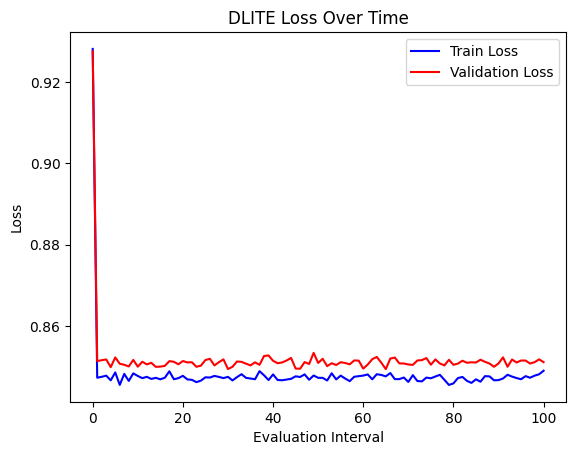

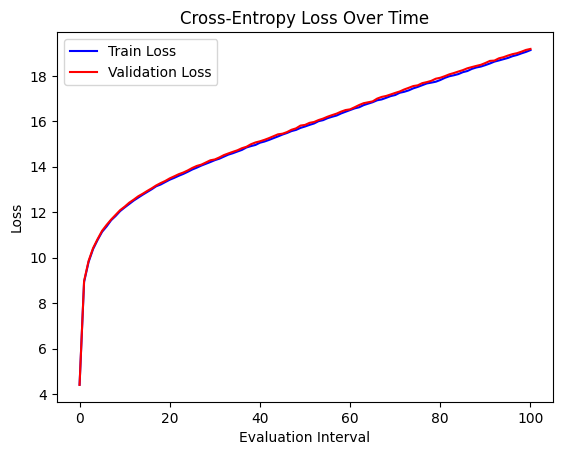

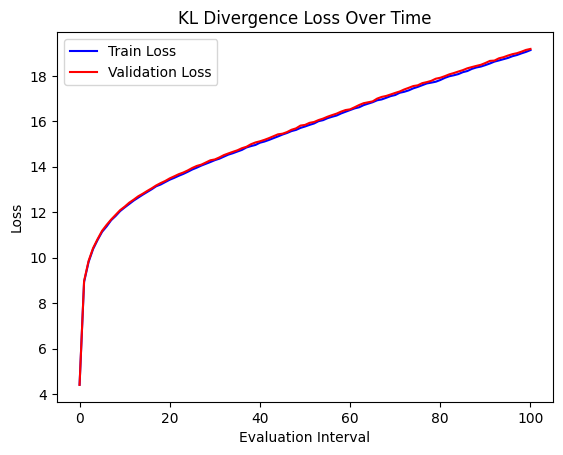

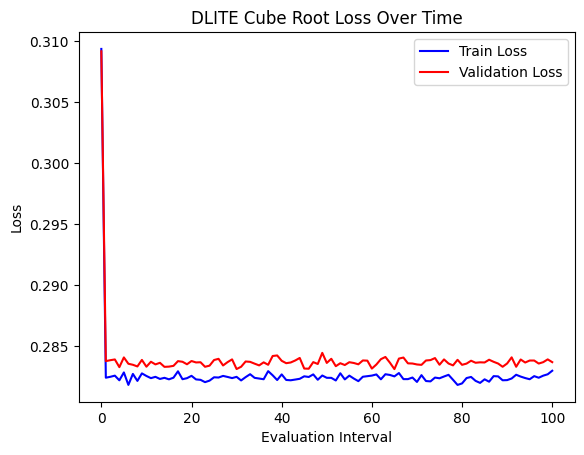

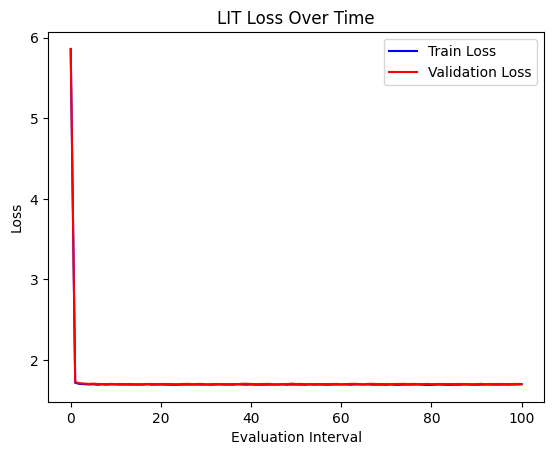

In [35]:
torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()
kl_loss = KLDivergenceLoss()
dlite_cuberoot_loss = DLITECubeRootLoss()
lit_loss = LITLoss()

# Lists to store the loss values
dlite_train_losses = []
dlite_val_losses = []
ce_train_losses = []
ce_val_losses = []
kl_train_losses = []
kl_val_losses = []
dlite_cuberoot_train_losses = []
dlite_cuberoot_val_losses = []
lit_train_losses = []
lit_val_losses = []




for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses, kl_losses, dlite_cuberoot_losses, lit_losses = estimate_loss()
        print(f"step {iter}: KL train loss {kl_losses['train']:.4f}, KL val loss {kl_losses['val']:.4f}")
        print(f"DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}")
        print(f"CE train loss {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}")
        print(f"DLITE Cube Root train loss {dlite_cuberoot_losses['train']:.4f}, DLITE Cube Root val loss {dlite_cuberoot_losses['val']:.4f}")
        print(f"LIT train loss {lit_losses['train']:.4f}, LIT val loss {lit_losses['val']:.4f}\n")


        # Append the losses for this iteration
        dlite_train_losses.append(dlite_losses['train'])
        dlite_val_losses.append(dlite_losses['val'])
        ce_train_losses.append(ce_losses['train'])
        ce_val_losses.append(ce_losses['val'])
        kl_train_losses.append(kl_losses['train'])
        kl_val_losses.append(kl_losses['val'])
        dlite_cuberoot_train_losses.append(dlite_cuberoot_losses['train'])
        dlite_cuberoot_val_losses.append(dlite_cuberoot_losses['val'])
        lit_train_losses.append(lit_losses['train'])
        lit_val_losses.append(lit_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)


    # Compute the DLITE loss using the flattened logits and targets
    loss = lit_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


!pip install matplotlib
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title):
    # Convert the lists to arrays for mathematical operations.
    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)

    # Create a new figure
    plt.figure()

    # Plot training and validation losses.
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')

    # Add titles, labels, and legend.
    plt.title(title)
    plt.xlabel('Evaluation Interval')
    plt.ylabel('Loss')
    plt.legend()

    # Show plot
    plt.show()

# Plotting DLITE Loss
plot_losses(dlite_train_losses, dlite_val_losses, 'DLITE Loss Over Time')

# Plotting Cross-Entropy Loss
plot_losses(ce_train_losses, ce_val_losses, 'Cross-Entropy Loss Over Time')

# Plotting KL Divergence Loss
plot_losses(kl_train_losses, kl_val_losses, 'KL Divergence Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(dlite_cuberoot_train_losses, dlite_cuberoot_val_losses, 'DLITE Cube Root Loss Over Time')

# Plotting DLITE Cube Root Loss
plot_losses(lit_train_losses, lit_val_losses, 'LIT Loss Over Time')

